# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

     |████████████████████████████████| 509 kB 21.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

     |████████████████████████████████| 188 kB 24.9 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

     |████████████████████████████████| 147 kB 21.3 MB/s eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

     |████████████████████████████████| 54 kB 566 kB/s  eta 0:00:01
You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [9]:
client = MongoClient(mongod_connect)
db = client.gp31 # use or create a database named demo
tweet_collection = db.lab11 #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [12]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [13]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [14]:
count = 100 #number of returned tweets, default and max is 100
geocode = "37.5247764,-77.5633011,150mi"  # defin the location, in Harrisonburg, VA
q = "covid19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [15]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Thu Nov 19 22:15:03 +0000 2020'
'Thu Nov 19 22:15:03 +0000 2020'
'Thu Nov 19 22:15:02 +0000 2020'
'Thu Nov 19 22:15:00 +0000 2020'
'Thu Nov 19 22:14:59 +0000 2020'
'Thu Nov 19 22:14:53 +0000 2020'
'Thu Nov 19 22:14:52 +0000 2020'
'Thu Nov 19 22:14:48 +0000 2020'
'Thu Nov 19 22:14:47 +0000 2020'
'Thu Nov 19 22:14:47 +0000 2020'
'Thu Nov 19 22:14:39 +0000 2020'
'Thu Nov 19 22:14:38 +0000 2020'
'Thu Nov 19 22:14:37 +0000 2020'
'Thu Nov 19 22:14:34 +0000 2020'
'Thu Nov 19 22:14:32 +0000 2020'
'Thu Nov 19 22:14:28 +0000 2020'
'Thu Nov 19 22:14:24 +0000 2020'
'Thu Nov 19 22:14:21 +0000 2020'
'Thu Nov 19 22:14:20 +0000 2020'
'Thu Nov 19 22:14:20 +0000 2020'
'Thu Nov 19 22:14:19 +0000 2020'
'Thu Nov 19 22:14:16 +0000 2020'
'Thu Nov 19 22:14:13 +0000 2020'
'Thu Nov 19 22:13:51 +0000 2020'
'Thu Nov 19 22:13:37 +0000 2020'
'Thu Nov 19 22:13:36 +0000 2020'
'Thu Nov 19 22:13:36 +0000 2020'
'Thu Nov 19 22:13:23 +0000 2020'
'Thu Nov 19 22:13:20 +0000 2020'
'Thu Nov 19 22:13:17 +0000 2020'
'Thu Nov 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [16]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Thu Nov 19 22:09:12 +0000 2020'
'Thu Nov 19 22:09:11 +0000 2020'
'Thu Nov 19 22:09:00 +0000 2020'
'Thu Nov 19 22:08:58 +0000 2020'
'Thu Nov 19 22:08:53 +0000 2020'
'Thu Nov 19 22:08:52 +0000 2020'
'Thu Nov 19 22:08:40 +0000 2020'
'Thu Nov 19 22:08:32 +0000 2020'
'Thu Nov 19 22:08:29 +0000 2020'
'Thu Nov 19 22:08:28 +0000 2020'
'Thu Nov 19 22:08:26 +0000 2020'
'Thu Nov 19 22:08:21 +0000 2020'
'Thu Nov 19 22:08:16 +0000 2020'
'Thu Nov 19 22:08:12 +0000 2020'
'Thu Nov 19 22:08:10 +0000 2020'
'Thu Nov 19 22:08:04 +0000 2020'
'Thu Nov 19 22:08:03 +0000 2020'
'Thu Nov 19 22:07:53 +0000 2020'
'Thu Nov 19 22:07:47 +0000 2020'
'Thu Nov 19 22:07:45 +0000 2020'
'Thu Nov 19 22:07:44 +0000 2020'
'Thu Nov 19 22:07:43 +0000 2020'
'Thu Nov 19 22:07:36 +0000 2020'
'Thu Nov 19 22:07:35 +0000 2020'
'Thu Nov 19 22:07:32 +0000 2020'
'Thu Nov 19 22:07:30 +0000 2020'
'Thu Nov 19 22:07:18 +0000 2020'
'Thu Nov 19 22:07:15 +0000 2020'
'Thu Nov 19 22:07:13 +0000 2020'
'Thu Nov 19 22:07:12 +0000 2020'
'Thu Nov 1

'Thu Nov 19 21:47:27 +0000 2020'
'Thu Nov 19 21:47:17 +0000 2020'
'Thu Nov 19 21:47:15 +0000 2020'
'Thu Nov 19 21:47:14 +0000 2020'
'Thu Nov 19 21:47:12 +0000 2020'
'Thu Nov 19 21:47:08 +0000 2020'
'Thu Nov 19 21:47:05 +0000 2020'
'Thu Nov 19 21:47:03 +0000 2020'
'Thu Nov 19 21:47:01 +0000 2020'
'Thu Nov 19 21:46:58 +0000 2020'
'Thu Nov 19 21:46:56 +0000 2020'
'Thu Nov 19 21:46:55 +0000 2020'
'Thu Nov 19 21:46:48 +0000 2020'
'Thu Nov 19 21:46:41 +0000 2020'
'Thu Nov 19 21:46:31 +0000 2020'
'Thu Nov 19 21:46:24 +0000 2020'
'Thu Nov 19 21:46:19 +0000 2020'
'Thu Nov 19 21:46:10 +0000 2020'
'Thu Nov 19 21:46:05 +0000 2020'
'Thu Nov 19 21:46:03 +0000 2020'
'Thu Nov 19 21:46:02 +0000 2020'
'Thu Nov 19 21:45:57 +0000 2020'
'Thu Nov 19 21:45:55 +0000 2020'
'Thu Nov 19 21:45:49 +0000 2020'
'Thu Nov 19 21:45:49 +0000 2020'
'Thu Nov 19 21:45:40 +0000 2020'
'Thu Nov 19 21:45:37 +0000 2020'
'Thu Nov 19 21:45:30 +0000 2020'
'Thu Nov 19 21:45:21 +0000 2020'
'Thu Nov 19 21:45:20 +0000 2020'
'Thu Nov 1

'Thu Nov 19 21:26:44 +0000 2020'
'Thu Nov 19 21:26:09 +0000 2020'
'Thu Nov 19 21:25:58 +0000 2020'
'Thu Nov 19 21:25:55 +0000 2020'
'Thu Nov 19 21:25:52 +0000 2020'
'Thu Nov 19 21:25:52 +0000 2020'
'Thu Nov 19 21:25:50 +0000 2020'
'Thu Nov 19 21:25:32 +0000 2020'
'Thu Nov 19 21:25:25 +0000 2020'
'Thu Nov 19 21:25:10 +0000 2020'
'Thu Nov 19 21:25:05 +0000 2020'
'Thu Nov 19 21:25:01 +0000 2020'
'Thu Nov 19 21:24:59 +0000 2020'
'Thu Nov 19 21:24:53 +0000 2020'
'Thu Nov 19 21:24:32 +0000 2020'
'Thu Nov 19 21:24:29 +0000 2020'
'Thu Nov 19 21:24:28 +0000 2020'
'Thu Nov 19 21:24:27 +0000 2020'
'Thu Nov 19 21:24:26 +0000 2020'
'Thu Nov 19 21:24:20 +0000 2020'
'Thu Nov 19 21:24:18 +0000 2020'
'Thu Nov 19 21:24:03 +0000 2020'
'Thu Nov 19 21:23:56 +0000 2020'
'Thu Nov 19 21:23:39 +0000 2020'
'Thu Nov 19 21:23:37 +0000 2020'
'Thu Nov 19 21:23:37 +0000 2020'
'Thu Nov 19 21:23:34 +0000 2020'
'Thu Nov 19 21:23:19 +0000 2020'
'Thu Nov 19 21:22:49 +0000 2020'
'Thu Nov 19 21:22:47 +0000 2020'
'Thu Nov 1

'Thu Nov 19 20:53:41 +0000 2020'
'Thu Nov 19 20:53:39 +0000 2020'
'Thu Nov 19 20:53:38 +0000 2020'
'Thu Nov 19 20:53:37 +0000 2020'
'Thu Nov 19 20:53:28 +0000 2020'
'Thu Nov 19 20:53:26 +0000 2020'
'Thu Nov 19 20:53:26 +0000 2020'
'Thu Nov 19 20:53:22 +0000 2020'
'Thu Nov 19 20:53:18 +0000 2020'
'Thu Nov 19 20:53:07 +0000 2020'
'Thu Nov 19 20:52:45 +0000 2020'
'Thu Nov 19 20:52:43 +0000 2020'
'Thu Nov 19 20:52:41 +0000 2020'
'Thu Nov 19 20:52:36 +0000 2020'
'Thu Nov 19 20:52:34 +0000 2020'
'Thu Nov 19 20:52:29 +0000 2020'
'Thu Nov 19 20:52:14 +0000 2020'
'Thu Nov 19 20:52:03 +0000 2020'
'Thu Nov 19 20:52:02 +0000 2020'
'Thu Nov 19 20:51:57 +0000 2020'
'Thu Nov 19 20:51:54 +0000 2020'
'Thu Nov 19 20:51:41 +0000 2020'
'Thu Nov 19 20:51:27 +0000 2020'
'Thu Nov 19 20:51:18 +0000 2020'
'Thu Nov 19 20:51:09 +0000 2020'
'Thu Nov 19 20:50:47 +0000 2020'
'Thu Nov 19 20:50:39 +0000 2020'
'Thu Nov 19 20:50:16 +0000 2020'
'Thu Nov 19 20:50:05 +0000 2020'
'Thu Nov 19 20:50:01 +0000 2020'
'Thu Nov 1

'Thu Nov 19 20:27:55 +0000 2020'
'Thu Nov 19 20:27:53 +0000 2020'
'Thu Nov 19 20:27:50 +0000 2020'
'Thu Nov 19 20:27:48 +0000 2020'
'Thu Nov 19 20:27:42 +0000 2020'
'Thu Nov 19 20:27:39 +0000 2020'
'Thu Nov 19 20:27:39 +0000 2020'
'Thu Nov 19 20:27:35 +0000 2020'
'Thu Nov 19 20:27:30 +0000 2020'
'Thu Nov 19 20:27:20 +0000 2020'
'Thu Nov 19 20:27:17 +0000 2020'
'Thu Nov 19 20:27:16 +0000 2020'
'Thu Nov 19 20:27:07 +0000 2020'
'Thu Nov 19 20:27:02 +0000 2020'
'Thu Nov 19 20:26:43 +0000 2020'
'Thu Nov 19 20:26:36 +0000 2020'
'Thu Nov 19 20:26:28 +0000 2020'
'Thu Nov 19 20:26:21 +0000 2020'
'Thu Nov 19 20:26:14 +0000 2020'
'Thu Nov 19 20:26:08 +0000 2020'
'Thu Nov 19 20:26:07 +0000 2020'
'Thu Nov 19 20:25:48 +0000 2020'
'Thu Nov 19 20:25:44 +0000 2020'
'Thu Nov 19 20:25:41 +0000 2020'
'Thu Nov 19 20:25:39 +0000 2020'
'Thu Nov 19 20:25:35 +0000 2020'
'Thu Nov 19 20:25:34 +0000 2020'
'Thu Nov 19 20:25:26 +0000 2020'
'Thu Nov 19 20:25:25 +0000 2020'
'Thu Nov 19 20:25:19 +0000 2020'
'Thu Nov 1

'Thu Nov 19 20:05:03 +0000 2020'
'Thu Nov 19 20:05:03 +0000 2020'
'Thu Nov 19 20:05:00 +0000 2020'
'Thu Nov 19 20:04:52 +0000 2020'
'Thu Nov 19 20:04:44 +0000 2020'
'Thu Nov 19 20:04:42 +0000 2020'
'Thu Nov 19 20:04:39 +0000 2020'
'Thu Nov 19 20:04:34 +0000 2020'
'Thu Nov 19 20:04:26 +0000 2020'
'Thu Nov 19 20:03:55 +0000 2020'
'Thu Nov 19 20:03:54 +0000 2020'
'Thu Nov 19 20:03:40 +0000 2020'
'Thu Nov 19 20:03:22 +0000 2020'
'Thu Nov 19 20:03:13 +0000 2020'
'Thu Nov 19 20:03:11 +0000 2020'
'Thu Nov 19 20:03:06 +0000 2020'
'Thu Nov 19 20:03:03 +0000 2020'
'Thu Nov 19 20:03:03 +0000 2020'
'Thu Nov 19 20:03:03 +0000 2020'
'Thu Nov 19 20:02:51 +0000 2020'
'Thu Nov 19 20:02:47 +0000 2020'
'Thu Nov 19 20:02:30 +0000 2020'
'Thu Nov 19 20:02:30 +0000 2020'
'Thu Nov 19 20:02:25 +0000 2020'
'Thu Nov 19 20:02:24 +0000 2020'
'Thu Nov 19 20:02:23 +0000 2020'
'Thu Nov 19 20:02:23 +0000 2020'
'Thu Nov 19 20:02:21 +0000 2020'
'Thu Nov 19 20:02:20 +0000 2020'
'Thu Nov 19 20:02:00 +0000 2020'
'Thu Nov 1

'Thu Nov 19 19:34:49 +0000 2020'
'Thu Nov 19 19:34:48 +0000 2020'
'Thu Nov 19 19:34:21 +0000 2020'
'Thu Nov 19 19:34:21 +0000 2020'
'Thu Nov 19 19:34:21 +0000 2020'
'Thu Nov 19 19:34:15 +0000 2020'
'Thu Nov 19 19:34:07 +0000 2020'
'Thu Nov 19 19:34:06 +0000 2020'
'Thu Nov 19 19:33:43 +0000 2020'
'Thu Nov 19 19:33:42 +0000 2020'
'Thu Nov 19 19:33:34 +0000 2020'
'Thu Nov 19 19:33:27 +0000 2020'
'Thu Nov 19 19:33:26 +0000 2020'
'Thu Nov 19 19:33:24 +0000 2020'
'Thu Nov 19 19:32:50 +0000 2020'
'Thu Nov 19 19:32:48 +0000 2020'
'Thu Nov 19 19:32:46 +0000 2020'
'Thu Nov 19 19:32:46 +0000 2020'
'Thu Nov 19 19:32:40 +0000 2020'
'Thu Nov 19 19:32:21 +0000 2020'
'Thu Nov 19 19:32:02 +0000 2020'
'Thu Nov 19 19:31:59 +0000 2020'
'Thu Nov 19 19:31:46 +0000 2020'
'Thu Nov 19 19:31:46 +0000 2020'
'Thu Nov 19 19:31:44 +0000 2020'
'Thu Nov 19 19:31:42 +0000 2020'
'Thu Nov 19 19:31:33 +0000 2020'
'Thu Nov 19 19:31:27 +0000 2020'
'Thu Nov 19 19:31:10 +0000 2020'
'Thu Nov 19 19:31:07 +0000 2020'
'Thu Nov 1

'Thu Nov 19 19:07:39 +0000 2020'
'Thu Nov 19 19:07:37 +0000 2020'
'Thu Nov 19 19:07:28 +0000 2020'
'Thu Nov 19 19:07:22 +0000 2020'
'Thu Nov 19 19:07:19 +0000 2020'
'Thu Nov 19 19:07:15 +0000 2020'
'Thu Nov 19 19:07:09 +0000 2020'
'Thu Nov 19 19:07:02 +0000 2020'
'Thu Nov 19 19:06:56 +0000 2020'
'Thu Nov 19 19:06:54 +0000 2020'
'Thu Nov 19 19:06:54 +0000 2020'
'Thu Nov 19 19:06:47 +0000 2020'
'Thu Nov 19 19:06:41 +0000 2020'
'Thu Nov 19 19:06:32 +0000 2020'
'Thu Nov 19 19:06:31 +0000 2020'
'Thu Nov 19 19:06:25 +0000 2020'
'Thu Nov 19 19:06:24 +0000 2020'
'Thu Nov 19 19:06:24 +0000 2020'
'Thu Nov 19 19:06:21 +0000 2020'
'Thu Nov 19 19:06:20 +0000 2020'
'Thu Nov 19 19:06:16 +0000 2020'
'Thu Nov 19 19:06:12 +0000 2020'
'Thu Nov 19 19:06:04 +0000 2020'
'Thu Nov 19 19:05:55 +0000 2020'
'Thu Nov 19 19:05:55 +0000 2020'
'Thu Nov 19 19:05:52 +0000 2020'
'Thu Nov 19 19:05:48 +0000 2020'
'Thu Nov 19 19:05:42 +0000 2020'
'Thu Nov 19 19:05:29 +0000 2020'
'Thu Nov 19 19:05:28 +0000 2020'
'Thu Nov 1

'Thu Nov 19 18:44:06 +0000 2020'
'Thu Nov 19 18:43:50 +0000 2020'
'Thu Nov 19 18:43:38 +0000 2020'
'Thu Nov 19 18:43:26 +0000 2020'
'Thu Nov 19 18:43:08 +0000 2020'
'Thu Nov 19 18:43:02 +0000 2020'
'Thu Nov 19 18:42:58 +0000 2020'
'Thu Nov 19 18:42:42 +0000 2020'
'Thu Nov 19 18:42:40 +0000 2020'
'Thu Nov 19 18:42:35 +0000 2020'
'Thu Nov 19 18:42:20 +0000 2020'
'Thu Nov 19 18:42:19 +0000 2020'
'Thu Nov 19 18:41:57 +0000 2020'
'Thu Nov 19 18:41:30 +0000 2020'
'Thu Nov 19 18:41:26 +0000 2020'
'Thu Nov 19 18:41:25 +0000 2020'
'Thu Nov 19 18:41:23 +0000 2020'
'Thu Nov 19 18:41:04 +0000 2020'
'Thu Nov 19 18:41:02 +0000 2020'
'Thu Nov 19 18:40:51 +0000 2020'
'Thu Nov 19 18:40:33 +0000 2020'
'Thu Nov 19 18:40:30 +0000 2020'
'Thu Nov 19 18:40:26 +0000 2020'
'Thu Nov 19 18:40:25 +0000 2020'
'Thu Nov 19 18:40:20 +0000 2020'
'Thu Nov 19 18:40:18 +0000 2020'
'Thu Nov 19 18:40:17 +0000 2020'
'Thu Nov 19 18:40:10 +0000 2020'
'Thu Nov 19 18:40:10 +0000 2020'
'Thu Nov 19 18:40:06 +0000 2020'
'Thu Nov 1

'Thu Nov 19 18:15:34 +0000 2020'
'Thu Nov 19 18:15:27 +0000 2020'
'Thu Nov 19 18:15:23 +0000 2020'
'Thu Nov 19 18:15:22 +0000 2020'
'Thu Nov 19 18:15:17 +0000 2020'
'Thu Nov 19 18:15:06 +0000 2020'
'Thu Nov 19 18:15:04 +0000 2020'
'Thu Nov 19 18:15:04 +0000 2020'
'Thu Nov 19 18:14:56 +0000 2020'
'Thu Nov 19 18:14:50 +0000 2020'
'Thu Nov 19 18:14:41 +0000 2020'
'Thu Nov 19 18:14:34 +0000 2020'
'Thu Nov 19 18:14:15 +0000 2020'
'Thu Nov 19 18:14:04 +0000 2020'
'Thu Nov 19 18:14:03 +0000 2020'
'Thu Nov 19 18:13:54 +0000 2020'
'Thu Nov 19 18:13:53 +0000 2020'
'Thu Nov 19 18:13:53 +0000 2020'
'Thu Nov 19 18:13:41 +0000 2020'
'Thu Nov 19 18:13:36 +0000 2020'
'Thu Nov 19 18:13:35 +0000 2020'
'Thu Nov 19 18:13:31 +0000 2020'
'Thu Nov 19 18:13:31 +0000 2020'
'Thu Nov 19 18:13:29 +0000 2020'
'Thu Nov 19 18:13:23 +0000 2020'
'Thu Nov 19 18:13:21 +0000 2020'
'Thu Nov 19 18:13:15 +0000 2020'
'Thu Nov 19 18:13:10 +0000 2020'
'Thu Nov 19 18:13:08 +0000 2020'
'Thu Nov 19 18:13:06 +0000 2020'
'Thu Nov 1

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [17]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

2655
2282


Create a text index and print the Tweets containing specific keywords. 

In [18]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [19]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pprint to display tweets

In [20]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: bloomrhealth
text: RT @criley_md: . @DrLindaMD "In the days of #COVID19 there is no place for war on science". Yes! 
Even in non-COVID19 times, there is no pl…
----
name: Jasminka Criley MD, FACP, FHM
text: . @DrLindaMD "In the days of #COVID19 there is no place for war on science". Yes! 
Even in non-COVID19 times, there… https://t.co/ek5hzjXF3h
----
name: University of California Health
text: 3/7  32 #COVID19 @UofCAHealth inpatients are on a ventilator.  5 COVID19 inpatients are on extracorporeal membrane… https://t.co/kjyjkoABZp
----
name: Sarah Nacman Show
text: CDC studies/reports support wearing a mask protects from the COVID19 and lowers virus transmission. #COVID19… https://t.co/lui0DM5QRe
----
name: Patti Stanger
text: So I’m am putting alert out on #dating while #COVID19 is crazy. If you both took #COVID19 tests wear a mask, social… https://t.co/Nqj88uGK6S
----
name: VarnWill
text: @mdnij34 #COVID19
----
name: Billy X
text: @DK8sam Covid19 issues?
----
name: On Dema

In [21]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "covid19"}}) # return tweets contain vote

Use pandas to display tweets

In [22]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,quoted_status_id,quoted_status_id_str,retweet_count,favorite_count,favorited,retweeted,lang,quoted_status,possibly_sensitive,extended_entities
0,5fb6eecc364f4e3dd5b6103f,Thu Nov 19 19:43:23 +0000 2020,1329510603728162816,1329510603728162816,"RT @criley_md: . @DrLindaMD ""In the days of #C...",False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://about.twitter.com/products/tw...",NaN,...,1.329507e+18,1329507141816823809,1,0,False,False,en,NaN,NaN,NaN
1,5fb6eecc364f4e3dd5b61047,Thu Nov 19 19:42:26 +0000 2020,1329510363864285184,1329510363864285184,". @DrLindaMD ""In the days of #COVID19 there is...",True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1.329507e+18,1329507141816823809,1,3,False,False,en,{'created_at': 'Thu Nov 19 19:29:38 +0000 2020...,False,NaN
2,5fb6eecf364f4e3dd5b61158,Thu Nov 19 19:12:41 +0000 2020,1329502876792614912,1329502876792614912,3/7 32 #COVID19 @UofCAHealth inpatients are o...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.mangotree.com"" rel=""nofoll...",1.329503e+18,...,NaN,NaN,0,0,False,False,en,NaN,False,NaN
3,5fb6eecb364f4e3dd5b61006,Thu Nov 19 19:50:17 +0000 2020,1329512340077809666,1329512340077809666,CDC studies/reports support wearing a mask pro...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1.329038e+18,1329038349852680192,0,1,False,False,en,{'created_at': 'Wed Nov 18 12:26:49 +0000 2020...,False,NaN
4,5fb6eec5364f4e3dd5b60df4,Thu Nov 19 20:39:27 +0000 2020,1329524712729239552,1329524712729239552,So I’m am putting alert out on #dating while #...,True,"{'hashtags': [{'text': 'dating', 'indices': [3...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,NaN,NaN,0,3,False,False,en,NaN,NaN,NaN
5,5fb6eebf364f4e3dd5b60bf8,Thu Nov 19 21:33:35 +0000 2020,1329538336600457219,1329538336600457219,@mdnij34 #COVID19,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.329156e+18,...,NaN,NaN,0,0,False,False,und,NaN,NaN,NaN
6,5fb6eec4364f4e3dd5b60d54,Thu Nov 19 20:56:23 +0000 2020,1329528971944333312,1329528971944333312,@DK8sam Covid19 issues?,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.329302e+18,...,NaN,NaN,0,0,False,False,en,NaN,NaN,NaN
7,5fb6eec0364f4e3dd5b60c26,Thu Nov 19 21:29:29 +0000 2020,1329537304902287360,1329537304902287360,RT @snaheedy: #LA #COVID19,False,"{'hashtags': [{'text': 'LA', 'indices': [14, 1...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1.329537e+18,1329536529111236609,3,0,False,False,und,NaN,NaN,NaN
8,5fb6eebf364f4e3dd5b60c15,Thu Nov 19 21:30:27 +0000 2020,1329537545919598592,1329537545919598592,RT @snaheedy: #LA #COVID19,False,"{'hashtags': [{'text': 'LA', 'indices': [14, 1...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/iphone"" r...",NaN,...,1.329537e+18,1329536529111236609,3,0,False,False,und,NaN,NaN,NaN
9,5fb6eecc364f4e3dd5b61038,Thu Nov 19 19:43:59 +0000 2020,1329510755285291008,1329510755285291008,#COVID19 https://t.co/vbJNdQEhYr,False,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'und', 'result_type': 'r...","<a href=""http://twitter.com/download/android"" ...",NaN,...,NaN,NaN,0,0,False,False,und,NaN,False,"{'media': [{'id': 1329510752835817474, '

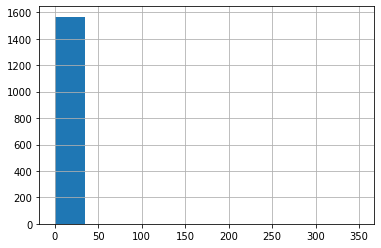

In [23]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count